In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the dataset
df = pd.read_excel('Data_forecast_covid2022.xlsx')

In [3]:
df = df[['Tanggal','POSITIF']]

In [4]:
df = df.groupby('Tanggal', sort=False, as_index=True).agg(sum)
df

,POSITIF
Tanggal,
01-01-2022,865415
02-01-2022,865518
03-01-2022,865690
04-01-2022,865805
05-01-2022,866064
...,...
13-11-2022,1474287
14-11-2022,1476058
15-11-2022,1478990


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(df[:257])
test_data = scaler.fit_transform(df[257:])

In [6]:
df.head()

,POSITIF
Tanggal,
01-01-2022,865415
02-01-2022,865518
03-01-2022,865690
04-01-2022,865805
05-01-2022,866064


In [7]:
train_data[:5]

array([[0.        ],
       [0.00018804],
       [0.00050204],
       [0.00071199],
       [0.00118482]])

In [8]:
scaler.inverse_transform(train_data[:5])

array([[1414292.        ],
       [1414305.50866528],
       [1414328.06682476],
       [1414343.14931512],
       [1414377.11770645]])

In [9]:
print("Shape of train data: " + str(train_data.shape))
print("Shape of test data: " + str(test_data.shape))

Shape of train data: (257, 1)
Shape of test data: (64, 1)


In [10]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

In [11]:
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [12]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (253, 3)
Shape of train labels: (253,)
Shape of test input: (60, 3)
Shape of test labels: (60,)


In [13]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (253, 1, 3)
Shape of train labels: (253,)
Shape of test input: (60, 1, 3)
Shape of test labels: (60,)


In [15]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
253/253 - 4s - loss: 0.1026 - 4s/epoch - 16ms/step
Epoch 2/100
253/253 - 1s - loss: 0.0071 - 700ms/epoch - 3ms/step
Epoch 3/100
253/253 - 1s - loss: 0.0037 - 672ms/epoch - 3ms/step
Epoch 4/100
253/253 - 1s - loss: 0.0016 - 668ms/epoch - 3ms/step
Epoch 5/100
253/253 - 1s - loss: 6.4632e-04 - 659ms/epoch - 3ms/step
Epoch 6/100
253/253 - 1s - loss: 3.4424e-04 - 665ms/epoch - 3ms/step
Epoch 7/100
253/253 - 1s - loss: 2.6504e-04 - 685ms/epoch - 3ms/step
Epoch 8/100
253/253 - 1s - loss: 2.4806e-04 - 696ms/epoch - 3ms/step
Epoch 9/100
253/253 - 1s - loss: 2.5313e-04 - 659ms/epoch - 3ms/step
Epoch 10/100
253/253 - 1s - loss: 2.5355e-04 - 664ms/epoch - 3ms/step
Epoch 11/100
253/253 - 1s - loss: 2.4678e-04 - 688ms/epoch - 3ms/step
Epoch 12/100
253/253 - 1s - loss: 2.5024e-04 - 662ms/epoch - 3ms/step
Epoch 13/100
253/253 - 1s - loss: 2.5513e-04 - 659ms/epoch - 3ms/step
Epoch 14/100
253/253 - 1s - loss: 2.4800e-04 - 668ms/epoch - 3ms/step
Epoch 15/100
253/253 - 1s - loss: 2.5532e-04 - 

In [17]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 7ms/step


In [18]:
testPredict[:5]

array([[0.02510444],
       [0.04071264],
       [0.05339695],
       [0.06865545],
       [0.0847176 ]], dtype=float32)

In [19]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [20]:
y_pred_test_lstm = model.predict(testX)
y_train_pred_lstm = model.predict(trainX)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(trainY[0], trainPredict[:,0])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(testY[0], testPredict[:,0])))

8/8 [==============================] - 0s 4ms/step
The R2 score on the Train set is:	1.000
The R2 score on the Test set is:	0.990


In [21]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 204.31 RMSE
Test Score: 1692.92 RMSE


In [22]:
dates = pd.date_range(start='2022-01-01 00:00:00', end='2022-12-31 00:00:00', periods=trainY.shape[1])
dates

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-02 10:40:00',
               '2022-01-03 21:20:00', '2022-01-05 08:00:00',
               '2022-01-06 18:40:00', '2022-01-08 05:20:00',
               '2022-01-09 16:00:00', '2022-01-11 02:40:00',
               '2022-01-12 13:20:00', '2022-01-14 00:00:00',
               ...
               '2022-12-18 00:00:00', '2022-12-19 10:40:00',
               '2022-12-20 21:20:00', '2022-12-22 08:00:00',
               '2022-12-23 18:40:00', '2022-12-25 05:20:00',
               '2022-12-26 16:00:00', '2022-12-28 02:40:00',
               '2022-12-29 13:20:00', '2022-12-31 00:00:00'],
              dtype='datetime64[ns]', length=253, freq=None)

In [23]:
trainActual = pd.DataFrame({'Precipitation': trainY[0]})
trainActual.index = dates

trainPredictdf = pd.DataFrame({'Precipitation': trainPredict[:,0]})
trainPredictdf.index = dates

In [24]:
trainActual

,Precipitation
2022-01-01 00:00:00,1.414343e+06
2022-01-02 10:40:00,1.414377e+06
2022-01-03 21:20:00,1.414412e+06
2022-01-05 08:00:00,1.414451e+06
2022-01-06 18:40:00,1.414488e+06
...,...
2022-12-25 05:20:00,1.485473e+06
2022-12-26 16:00:00,1.485621e+06
2022-12-28 02:40:00,1.485733e+06
2022-12-29 13:20:00,1.485832e+06


In [25]:
trainPredictdf

,Precipitation
2022-01-01 00:00:00,1414237.375
2022-01-02 10:40:00,1414259.625
2022-01-03 21:20:00,1414297.375
2022-01-05 08:00:00,1414340.000
2022-01-06 18:40:00,1414390.500
...,...
2022-12-25 05:20:00,1485790.250
2022-12-26 16:00:00,1485955.500
2022-12-28 02:40:00,1486109.875
2022-12-29 13:20:00,1486237.000


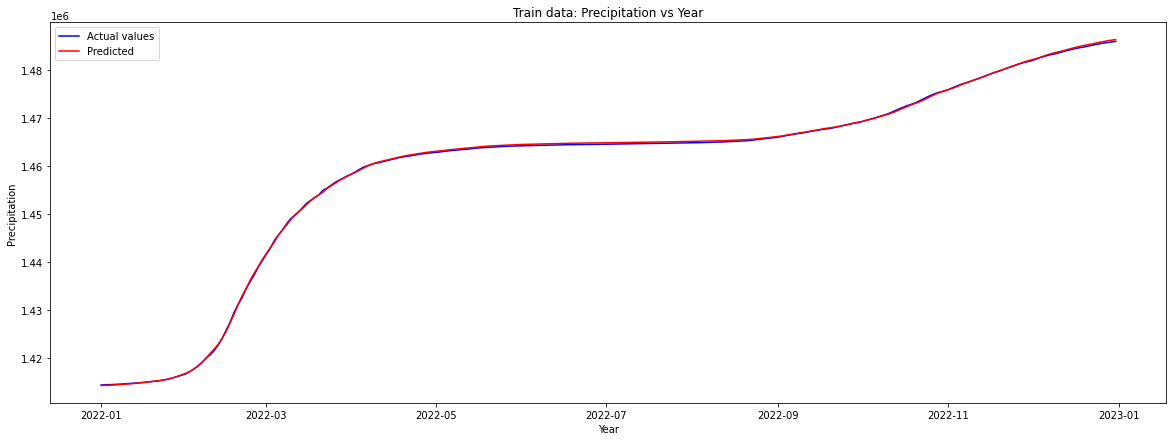

In [26]:
plt.figure(figsize=(20,7))
plt.plot(trainActual, color='blue', label='Actual values')
plt.plot(trainPredictdf, color='red', label='Predicted')
plt.title('Train data: Precipitation vs Year')
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.legend(loc='best')
plt.savefig('LSTMCov2022.jpg',  dpi=300, bbox_inches='tight')